In [2]:
import numpy as np
import numpy.linalg as nla
import numpy.random as random
import scipy.linalg as la
import scipy.sparse as sp
from matplotlib import pyplot as plt
from itertools import product
import time
from tqdm import tqdm
from IPython.display import clear_output
from numpy import fft

In [3]:
# -----------------------------# ------------------------------
# Majorana Wannier function constructor

def majorana_wannier_function(mu, R, N, nshell=None):
    # k-grids in radians per lattice spacing (FFT ordering)
    k = 2 * np.pi * np.fft.fftfreq(N, d=1.0)

    dy = -2 * np.sin(k)
    dz = -(2 * np.cos(k) + mu)
    dmag = np.sqrt(dy**2 + dz**2)
    dmag = np.where(dmag == 0, 1e-15, dmag)

    pauli_x = np.array([[0, 1], [1, 0]], dtype=complex)
    pauli_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    pauli_z = np.array([[1, 0], [0, -1]], dtype=complex)
    Id = np.eye(2, dtype=complex)

    dk = (dy[:, None, None] * pauli_y + dz[:, None, None] * pauli_z) / dmag[:, None, None]
    Pminus = 0.5 * (Id - dk)

    tau = (1 / np.sqrt(2)) * np.array([1, 1], dtype=complex)

    phase_shift = np.exp(-1j * k * R)  # shift χ(r) → χ(r - R)

    alpha_k = Pminus @ tau
    alpha_k /= np.linalg.norm(alpha_k, axis=1, keepdims=True)

    chi_R = np.empty((N, 2), dtype=complex)
    chi_R[:, 0] = np.fft.ifft(phase_shift * alpha_k[:, 0])
    chi_R[:, 1] = np.fft.ifft(phase_shift * alpha_k[:, 1])

    M = pauli_x + pauli_z

    Pi_R = np.empty((N, 2), dtype=complex)
    Pi_R = np.real(np.einsum("ij,jk->ik", chi_R, M))

    if nshell is not None:
        indices = np.arange(N)
        dist = ((indices - R + N//2) % N) - N//2  # now in [-N/2, N/2]
        mask = np.abs(dist) <= int(nshell)
        Pi_R[~mask, :] = 0.0

    Pi_R[:, 0] /= np.linalg.norm(Pi_R[:, 0])
    Pi_R[:, 1] /= np.linalg.norm(Pi_R[:, 1])

    

    return Pi_R


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_majorana_pi_components(Pi_R):
    """
    Plot real/imag parts of the two Π components vs lattice site.
    The lattice index is fft-shifted so the chosen center sits at 0.
    """
    Pi_R = np.asarray(Pi_R)
    if Pi_R.ndim != 2 or Pi_R.shape[1] != 2:
        raise ValueError("Pi_R must have shape (N, 2).")

    N = Pi_R.shape[0]
    Pi_shift = np.fft.fftshift(Pi_R, axes=0)
    sites = np.arange(N) - N // 2

    components = [(r"$\Pi_1(r-R)$", Pi_shift[:, 0]), (r"$\Pi_2(r-R)$", Pi_shift[:, 1])]

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharex=True)
    for ax, (label, data) in zip(np.atleast_1d(axes), components):
        ax.plot(sites, data.real, '-o', lw=1.2, color="#3366cc", label="Re")
        ax.axhline(0.0, color="0.4", lw=0.6)
        ax.set_title(label)
        ax.set_ylabel("Amplitude")
        ax.grid(alpha=0.25)

    axes[0].set_xlabel("Lattice site")
    axes[1].set_xlabel("Lattice site")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
    fig.tight_layout(rect=(0, 0, 1, 0.92))
    plt.show()


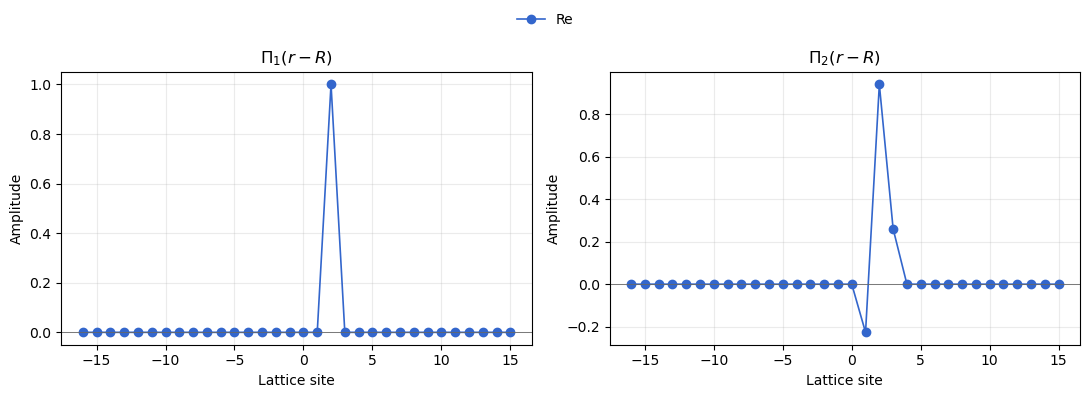

In [5]:
mu = 4
R = 2
N = 32

Pi_R = majorana_wannier_function(mu, R, N, nshell=1)
plot_majorana_pi_components(Pi_R)


In [6]:
print(Pi_R[:,0] @ Pi_R[:,0])  
print(Pi_R[:,1] @ Pi_R[:,1])

1.0
1.0


In [7]:
mu = 6
R1 = 4
R2 = 6
N = 128
Pi_1 = majorana_wannier_function(mu, R1, N)
Pi_2 = majorana_wannier_function(mu, R2, N)
print(Pi_1[:,0] @ Pi_2[:,0])  
print(Pi_1[:,1] @ Pi_2[:,1])

-2.6888213877640485e-17
-2.42861286636753e-17


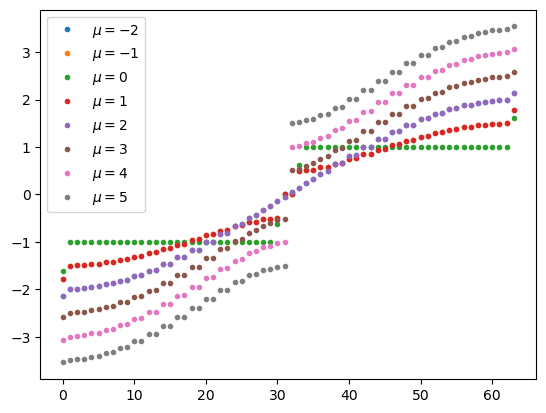

In [ ]:
# consructing real space kitaev hamiltonian in Majorana basis
def kitaev_majorana_hamiltonian(N, mu, PBCs = False):
    # we're setting t = Delta = 1
    # ignoring extra factor of 1/2 from BdG basis construction
    M = -mu*np.eye(N, dtype=np.complex128) - 2*np.eye(N, k=-1, dtype=np.complex128)
    if PBCs:
        M[0,-1] = -2
    zero_block = np.zeros_like(M)
    H = 1j/2*np.block([[zero_block, M], [-M.T, zero_block]])
    return H

N = 32

for mu in [-2,-1,0,1,2,3,4,5]:
    H = kitaev_majorana_hamiltonian(N, mu, PBCs=True)
    eigvals = np.linalg.eigh(H)[0]
    plt.plot(eigvals,'o', markersize=3, label = rf'$\mu={mu}$')
plt.legend()

In [21]:
def kitaev_GS_covariance(N, mu, PBCs = True):
    H = kitaev_majorana_hamiltonian(N, mu, PBCs)
    eig_result = np.linalg.eigh(H)
    D = np.diag(eig_result[0])
    U = eig_result[1]
    G = 1j*U @ np.sign(D) @ U.conj().T
    return G

N = 32
mu = 1
G = kitaev_GS_covariance(N, mu, PBCs=True)



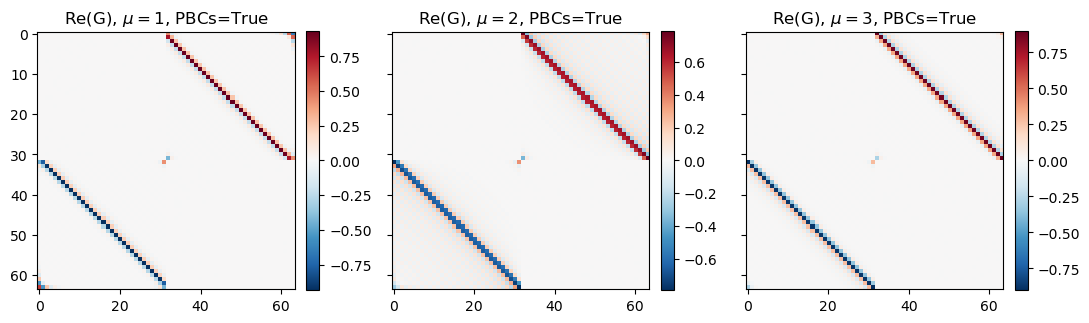

In [22]:

fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharey=True)
for mu in [1, 2, 3]:
    G = kitaev_GS_covariance(N, mu, PBCs=True)
    im = axs[mu-1].imshow(np.real(G), cmap="RdBu_r")
    axs[mu-1].set_title(rf"Re(G), $\mu={mu}$, PBCs=True")
    fig.colorbar(im, ax=axs[mu-1], fraction=0.046, pad=0.04)


fig.tight_layout()
plt.show()




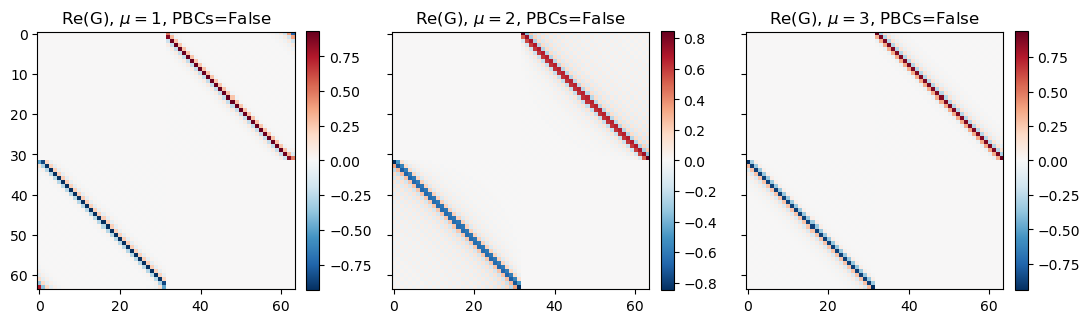

In [23]:

fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharey=True)
for mu in [1, 2, 3]:
    G = kitaev_GS_covariance(N, mu, PBCs=False)
    im = axs[mu-1].imshow(np.real(G), cmap="RdBu_r")
    axs[mu-1].set_title(rf"Re(G), $\mu={mu}$, PBCs=False")
    fig.colorbar(im, ax=axs[mu-1], fraction=0.046, pad=0.04)


fig.tight_layout()
plt.show()

max(G^2 + I) =
 1.9705593466920498e-15
max(G^T + G) =
 2.220446049250313e-16
eigenvalues of iG = [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]


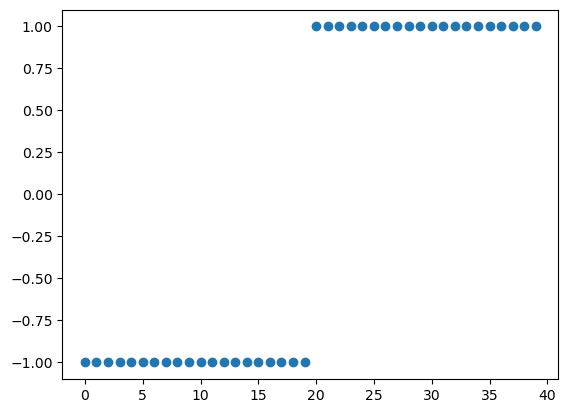

In [9]:
# initialization helpers for random covariance matrices
def random_so_2n(n, rng=None):
    """Generate a random O in SO(2n) via exp of a Gaussian antisymmetric matrix."""
    rng = np.random.default_rng(rng)
    X = rng.normal(size=(2 * n, 2 * n))
    A = X - X.T                          # antisymmetric
    return la.expm(A)                       # exp of antisymmetric is orthogonal with det=+1

def random_majorana_covariance(n, rng=None):
    """
    Build a random 2n x 2n Majorana-basis covariance matrix.
    Steps:
      1) random ±1 signs (length n)
      2) diag(s) of size n
      3) kron with [[0,1],[-1,0]]
      4) conjugate by random O in SO(2n)
    """
    rng = np.random.default_rng(rng)
    signs = rng.choice([-1, 1], size=n)
    diag_signs = np.diag(signs)
    J = np.array([[0, 1], [-1, 0]], dtype=float)
    base = np.kron(J, diag_signs)        
    O = random_so_2n(n, rng)
    cov = O @ base @ O.T
    return cov 

# check
n = 20
G = random_majorana_covariance(n)
print("max(G^2 + I) =\n", np.max(G @ G + np.eye(2*n)))  # should be close to zero matrix
print("max(G^T + G) =\n", np.max(G.T + G))              # should be close to zero matrix
eigenvalues = np.linalg.eigvalsh(1j * G)
print("eigenvalues of iG =", eigenvalues)
plt.plot(eigenvalues,'o')   # should be ±1

In [ ]:
# measurement updates to covariance matrices
# solving for inverse with Tikhonov regularization
def reg_solve(K, B, eps=1e-9):
    """
    Solve K X = B with a small Tikhonov ridge if needed; fall back to pinv.
    """
    try:
        return np.linalg.solve(K, B)
    except np.linalg.LinAlgError:
        pass
    n = K.shape[0]
    K_reg = K + eps * np.eye(n, dtype=K.dtype)
    try:
        return np.linalg.solve(K_reg, B)
    except np.linalg.LinAlgError:
        return np.linalg.pinv(K_reg) @ B

# ancilla layer measurement update
def measure_ancilla_layer(G, P, pos_parity=True, Asymm=True):
    '''Measure parity on bottom layer.'''
    Ntot = G.shape[0]
    Nlayer = Ntot // 2
    G = np.asarray(G, dtype=np.complex128)
    P = np.asarray(P, dtype=np.complex128)
    Il = np.eye(Nlayer, dtype=np.complex128)
    Gpp = G[:Nlayer, :Nlayer]
    Gaa = G[Nlayer:, Nlayer:]
    Gpa = G[:Nlayer, Nlayer:]

    Psi_aa = -np.block([[np.zeros_like(P), P],
                       [-P.T, np.zeros_like(P)]])
    
    # adjust sign for pos/neg parity measurement
    if not pos_parity:
        Psi_aa = -Psi_aa
    
    # physical layer update
    Gpp_prime = Gpp + Gpa @ reg_solve(Psi_aa @ Gaa + Il, Psi_aa @ Gpa.T)

    Gprime = np.block([[Gpp_prime, np.zeros_like(Psi_aa)],
                        [np.zeros_like(Psi_aa), -Psi_aa]])

    if Asymm:
        Gprime = 0.5 * (Gprime - Gprime.T)
        
    return Gprime
